In [1]:
import re
import os
import numpy as np
import pandas as pd

In questo notebook saranno definiti tutti i dataset di feature linguistiche, quindi:
1) un dataset con le feature linguistiche del testo totale del prompt e del target (quindi considerati unico testo).
2) un dataset con i vettori di feature concatenati, quindi vettore del prompt concatenato al vettore del target.
3) un dataset con i vettori derivati dalla differenza tra il vettore del prompt e quello del target.

Inoltre, sempre in questo notebook i dataaset sono stati normalizzati, e poi salvati in formato .npz

## DATASET 1

In [2]:
def get_dataset(path:str):
    # per formare il dataset 1

    df = pd.read_csv(path, sep='\t')

    # creo preventivamente le matrici finali
    train_X = np.zeros((8000, df.shape[1]-1))
    train_y = np.zeros((8000))

    test_X = np.zeros((800, df.shape[1]-1))
    test_y = np.zeros((800))

    feature_names = np.array(df.columns[1:])
    
    # assegno ogni vettore al posto corretto nella matrice, anche per mantenere lo stesso ordine dei file
    for i in range(df.shape[0]):
        record = df.iloc[i] # il record completo
        splitted_fname = record['Filename'].split('/')
        loc = splitted_fname[1] # test o train
        pos = int(splitted_fname[2].split('_')[0]) # l'id numerico del file
        class_ = int(splitted_fname[2].split('_')[1].split('.')[0]) # la classe di output

        if loc == 'train':
            train_X[pos, :] = df.iloc[i,1:]
            train_y[pos] = class_
        elif loc == 'test':
            test_X[pos, :] = df.iloc[i,1:]
            test_y[pos] =  class_

        
    return train_X, train_y, test_X, test_y, feature_names
        



train_X, train_y, test_X, test_y, feature_names = get_dataset('../data/_profiled/TED_LP.csv')

In [3]:
train_X.shape, test_X.shape

((8000, 142), (800, 142))

## DATASET 2

In [2]:
def get_dataset_concatenated(path:str):
    # per formare il dataset 2

    df = pd.read_csv(path, sep='\t')

    # creo preventivamente le matrici finali, stavolta hanno il doppio delle colonne
    n_feat = df.shape[1]-1

    train_X = np.zeros((8000, n_feat*2))
    train_y = np.zeros((8000))

    test_X = np.zeros((800, n_feat*2))
    test_y = np.zeros((800))

    # distinguo le feature del prompt da quelle del target
    feature_names = np.array(list(df.columns[1:]) + [f'target_{feature}' for feature in df.columns[1:]])

    for i in range(df.shape[0]):
        record = df.iloc[i]
        splitted_fname = record['Filename'].split('/')
        loc = splitted_fname[1]
        resplit = splitted_fname[2].split('_') # seconda parte del filename
        pos = int(resplit[0])
        class_ = int(resplit[1])
        type_ = resplit[2].split('.')[0] # target o prompt

        if loc == 'train':
            if type_ == 'prompt':
                train_X[pos,0:n_feat] = df.iloc[i,1:]
                train_y[pos] = class_
            elif type_== 'target':
                train_X[pos,n_feat:] = df.iloc[i,1:]
            else:
                raise Exception
        elif loc == 'test':
            if type_ == 'prompt':
                test_X[pos,0:n_feat] = df.iloc[i,1:]
                test_y[pos] = class_
            elif type_== 'target':
                test_X[pos,n_feat:] = df.iloc[i,1:]
            else:
                raise Exception
        else:
            raise Exception
  
    return train_X, train_y, test_X, test_y, feature_names



train_X_concat, train_y_concat, test_X_concat, test_y_concat, feature_names_concat = get_dataset_concatenated('../data/_profiled/TED_split_LP.csv')

In [5]:
train_X_concat.shape, train_y_concat.shape, test_X_concat.shape, test_y_concat.shape

((8000, 284), (8000,), (800, 284), (800,))

## DATASET 3

In [3]:
# per il dataset 3 basta fare:
train_X_diff = np.abs(train_X_concat[:,:142] - train_X_concat[:,142:])
test_X_diff = np.abs(test_X_concat[:,:142] - test_X_concat[:,142:])

## DATASET 4

Creo un altro dataset, raggruppando le feature linguistiche per il loro tipo, e calcolando poi per ogni gruppo la cosine similarity:

In [7]:
feature_names

array(['n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok',
       'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200',
       'ttr_form_chunks_100', 'ttr_form_chunks_200', 'upos_dist_ADJ',
       'upos_dist_ADP', 'upos_dist_ADV', 'upos_dist_AUX',
       'upos_dist_CCONJ', 'upos_dist_DET', 'upos_dist_INTJ',
       'upos_dist_NOUN', 'upos_dist_NUM', 'upos_dist_PART',
       'upos_dist_PRON', 'upos_dist_PROPN', 'upos_dist_PUNCT',
       'upos_dist_SCONJ', 'upos_dist_SYM', 'upos_dist_VERB',
       'upos_dist_X', 'lexical_density', 'verbs_tense_dist_Fut',
       'verbs_tense_dist_Imp', 'verbs_tense_dist_Past',
       'verbs_tense_dist_Pres', 'verbs_mood_dist_Cnd',
       'verbs_mood_dist_Imp', 'verbs_mood_dist_Ind',
       'verbs_mood_dist_Sub', 'verbs_form_dist_Fin',
       'verbs_form_dist_Ger', 'verbs_form_dist_Inf',
       'verbs_form_dist_Part', 'verbs_num_pers_dist_+3',
       'verbs_num_pers_dist_Plur+', 'verbs_num_pers_dist_Plur+1',
       'verbs_num_pers_dist_Plur+2', 'verbs_n

In [16]:
# consulto la profiling-legend e prendo gli indici a mano
list(feature_names).index('subordinate_dist_5')

141

In [27]:
# lista che indica gli indici di inizio e di fine per ogni gruppo di feature
grouped_features = [
    ('lexical_variety' , (4,7)),
    ('morfo_info' , (8,25)),
    ('inflectional_morfo' , (26, 63)),
    ('verbal_struct'  , (64, 73)),
    ('tree_struct' , (74, 85)),
    ('order_el' , (86,89)),
    ('syntact_rel' , (90,131)),
    ('subordination' , (132, 141))
]

In [19]:
train_X_prompt = train_X_concat[:,:142]
train_X_target = train_X_concat[:,142:]

test_X_prompt = test_X_concat[:,:142]
test_X_target = test_X_concat[:,142:]

train_X_prompt.shape, train_X_target.shape, test_X_prompt.shape, test_X_target.shape, 

((8000, 142), (8000, 142), (800, 142), (800, 142))

In [24]:
[1,2,3,4,5,6][0:5]


[1, 2, 3, 4, 5]

In [120]:
import math

train_X_grouped_cosine = np.zeros((8000, 8))
test_X_grouped_cosine = np.zeros((800, 8))

# creo il training set
for i in range(train_X_prompt.shape[0]):
    prompt = train_X_prompt[i,:]
    target = train_X_target[i,:]

    j = 0
    for el in grouped_features:
        name,range_ = el[0], el[1]
        val_prompt = prompt[range_[0]:range_[1]]
        val_target = target[range_[0]:range_[1]]

        if j == 0: # perchè gran parte della ttr sono zero quindi non posso fare la cosine similarity, quindi faccio la differenza media
            train_X_grouped_cosine[i,j] = np.mean(val_prompt-val_target)
            j+=1
            continue
        
        cos_sim = np.dot(val_prompt, val_target)/(np.linalg.norm(val_prompt)*np.linalg.norm(val_target))
        if math.isnan(cos_sim):
            cos_sim = 1
        train_X_grouped_cosine[i,j] = cos_sim

        j+=1


# creo il test set
for i in range(test_X_prompt.shape[0]):
    prompt = test_X_prompt[i,:]
    target = test_X_target[i,:]

    j = 0
    for el in grouped_features:
        name,range_ = el[0], el[1]
        val_prompt = prompt[range_[0]:range_[1]]
        val_target = target[range_[0]:range_[1]]

        if j == 0: # perchè gran parte della ttr sono zero quindi non posso fare la cosine similarity, quindi faccio la differenza media
            train_X_grouped_cosine[i,j] = np.mean(val_prompt-val_target)
            j+=1
            continue
        
        cos_sim = np.dot(val_prompt, val_target)/(np.linalg.norm(val_prompt)*np.linalg.norm(val_target))
        if math.isnan(cos_sim):
            cos_sim = 1
        test_X_grouped_cosine[i,j] = cos_sim

        j+=1



C:\Users\giuli\AppData\Local\Temp\ipykernel_6824\3484241914.py:21: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = np.dot(val_prompt, val_target)/(np.linalg.norm(val_prompt)*np.linalg.norm(val_target))
C:\Users\giuli\AppData\Local\Temp\ipykernel_6824\3484241914.py:44: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = np.dot(val_prompt, val_target)/(np.linalg.norm(val_prompt)*np.linalg.norm(val_target))


In [122]:
np.isnan(np.sum(train_X_grouped_cosine))

False

In [121]:
np.isnan(np.sum(test_X_grouped_cosine))

False

## CONTROLLI

Qualche controllo sui dataset:

In [87]:
np.unique(train_y == train_y_concat), np.unique(test_y == test_y_concat)

(array([ True]), array([ True]))

In [88]:
np.unique(train_y == (np.array([0]*4000 + [1]*4000)))

array([ True])

In [89]:
# controllo che le label del training set siano corrette

id_class_dict = {int(name.split('_')[0]):int(name.split('_')[1].split('.')[0]) for name in os.listdir('../data/_profiled/TED/train')}
for i in range(train_y.shape[0]):
    label = train_y[i]
    if label != id_class_dict[i]:
        print('ERRORE')


## NORMALIZZAZIONE

Normalizzo con z-score normalization:

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X_norm = scaler.fit_transform(train_X)
test_X_norm = scaler.transform(test_X)

scaler = MinMaxScaler()
train_X_concat_norm = scaler.fit_transform(train_X_concat)
test_X_concat_norm = scaler.transform(test_X_concat)

scaler = MinMaxScaler()
train_X_diff_norm = scaler.fit_transform(train_X_diff)
test_X_diff_norm = scaler.transform(test_X_diff)

scaler = MinMaxScaler()
train_X_grouped_cosine_norm = scaler.fit_transform(train_X_grouped_cosine)
test_X_grouped_cosine_norm = scaler.transform(test_X_grouped_cosine)


## SALVATAGGIO

Salvo i dataset che mi servono:

In [92]:
np.savez(file='../data/_profiled/TED_profiling_concat', X_train=train_X_concat_norm, y_train=train_y_concat, X_test=test_X_concat_norm, y_test=test_y_concat, feat_names=feature_names_concat)
np.savez(file='../data/_profiled/TED_profiling_diff', X_train=train_X_diff_norm, y_train=train_y, X_test=test_X_diff_norm, y_test=test_y, feat_names=feature_names)
np.savez(file='../data/_profiled/TED_profiling', X_train=train_X_norm, y_train=train_y, X_test=test_X_norm, y_test=test_y, feat_names=feature_names)
np.savez(file='../data/_profiled/TED_profiling_grouped', X_train=train_X_grouped_cosine_norm, y_train=train_y, X_test=test_X_grouped_cosine_norm, y_test=test_y, feat_names=[el[0] for el in grouped_features])

## PLOT PCA

In [29]:
import matplotlib.pyplot as plt

def plot_pca(X_pca, y_train):
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.3)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

Provo a visualizzare i dataset in una spazio bidimensionale grazie alla PCA

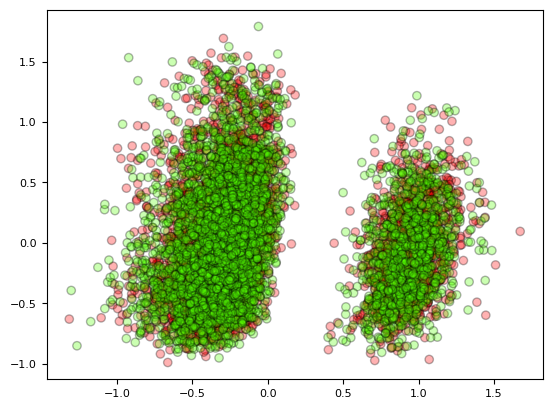

In [17]:
# dataset 1
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_X_norm)
plot_pca(X_pca, train_y)

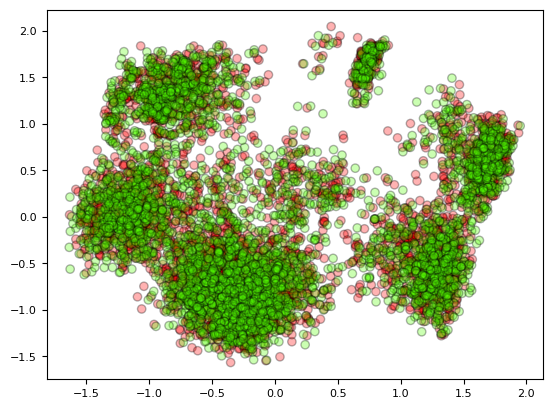

In [93]:
# dataset 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_X_concat_norm)
plot_pca(X_pca, train_y)

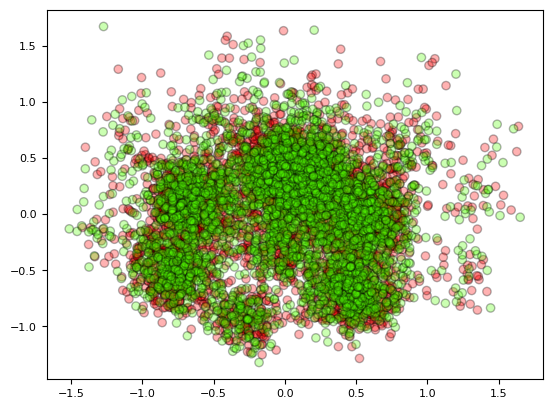

In [19]:
# dataset 3
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_X_diff_norm)
plot_pca(X_pca, train_y)

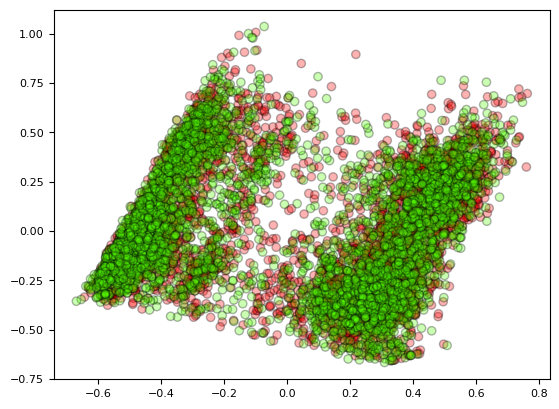

In [94]:
# dataset 3
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_X_grouped_cosine_norm)
plot_pca(X_pca, train_y)